In [131]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [132]:
import pandas as pd

pd.set_option("display.max_rows", 500)

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

sns.set()

import warnings

warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.stattools import adfuller

from statistics import median, mean

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Read data

In [133]:
df_accounts = pd.read_csv(
    "../data/accounts_enough_history.csv", parse_dates=["update_date"]
)
df_transactions = pd.read_csv(
    "../data/transactions_enough_history.csv", parse_dates=["date"]
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [140]:
print(f"Number of expenses rows: {len(df_transactions[df_transactions['amount'] < 0])}")

Number of expenses rows: 16406


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Resample into weeks and aggregate expenses

In [134]:
def _sum_negative_transactions(x: pd.Series) -> float:
    """Return sum of negative transactions only."""
    return x[x < 0].sum()


def _resample_per_week_unique_account(df: pd.DataFrame) -> pd.DataFrame:
    """Resample date into weeks for a unique account."""
    account_id = df["account_id"].iloc[0]

    temporary_df = df[df["account_id"] == account_id].sort_values(
        by="date", ascending=True
    )[["date", "amount"]]

    temporary_df = temporary_df.set_index("date", drop=True)

    temporary_df = (
        temporary_df.resample("W-MON").agg(_sum_negative_transactions).reset_index()
    )
    temporary_df["account_id"] = account_id

    return temporary_df


def get_new_resample_expenses_df(df: pd.DataFrame) -> pd.DataFrame:
    """Return a dataframe with resampled data into weeks and keep only expenses."""
    transactions_dfs = [data for _, data in df.groupby("account_id")]

    return pd.concat(
        [
            _resample_per_week_unique_account(
                df=df_unique_account,
            )
            for df_unique_account in transactions_dfs
        ]
    ).reset_index(drop=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

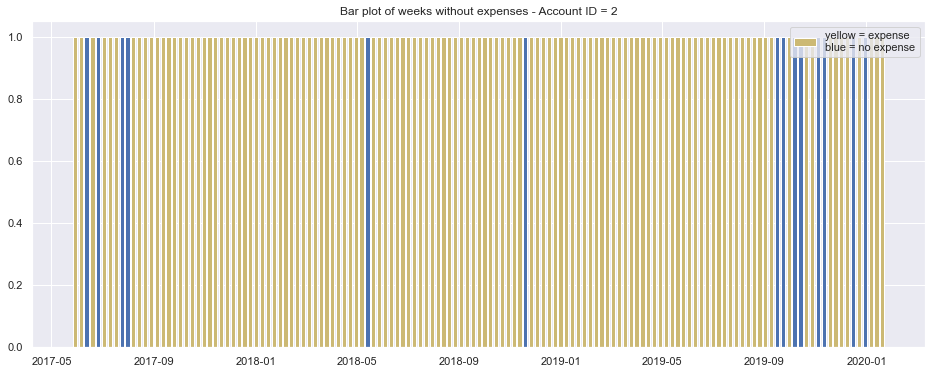

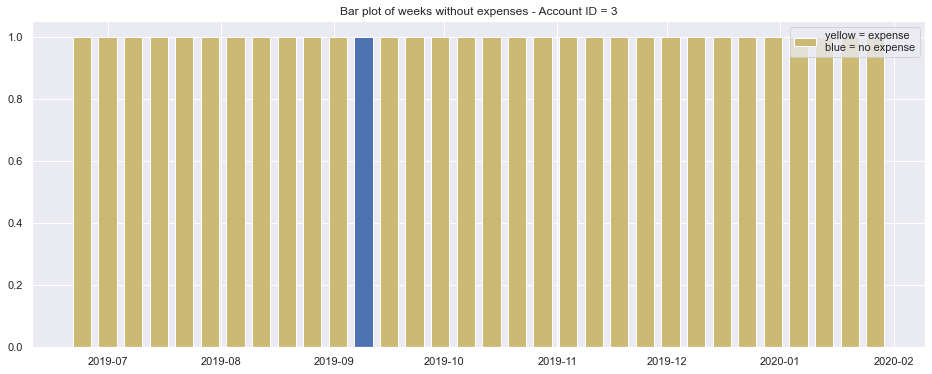

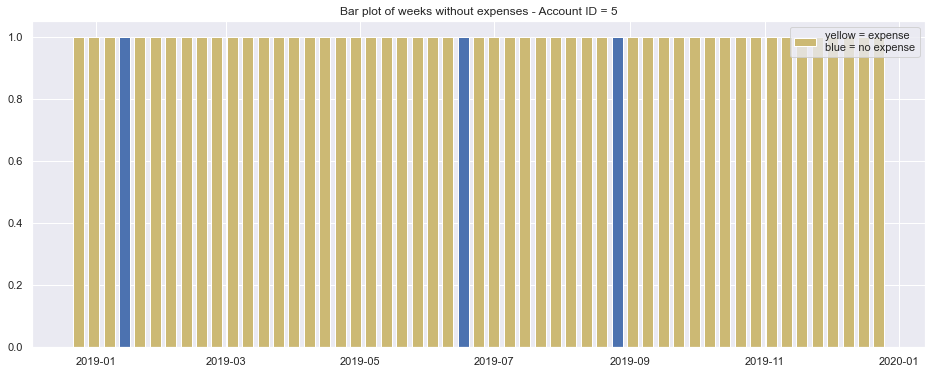

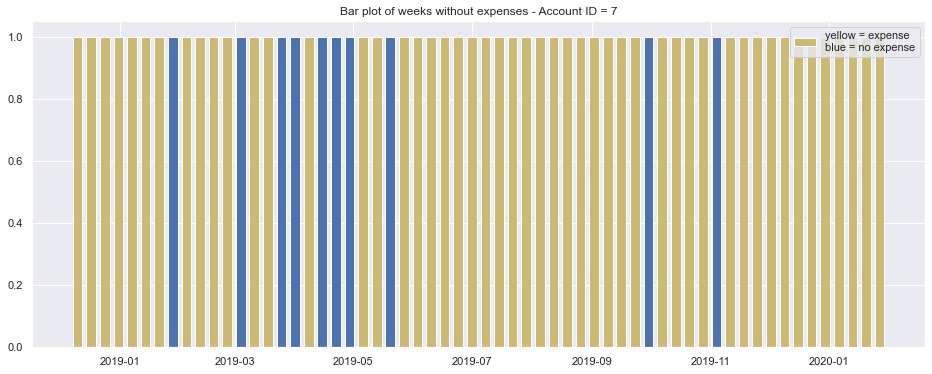

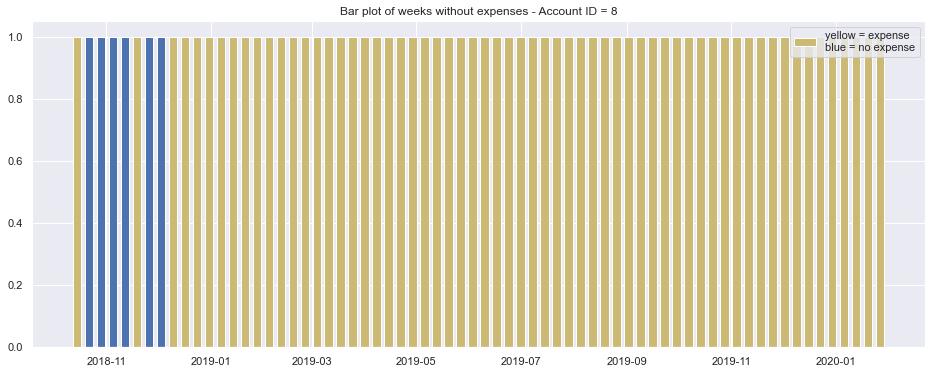

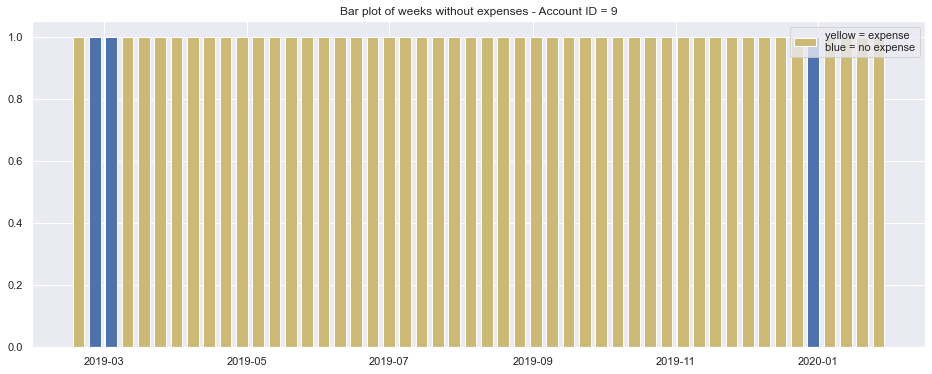

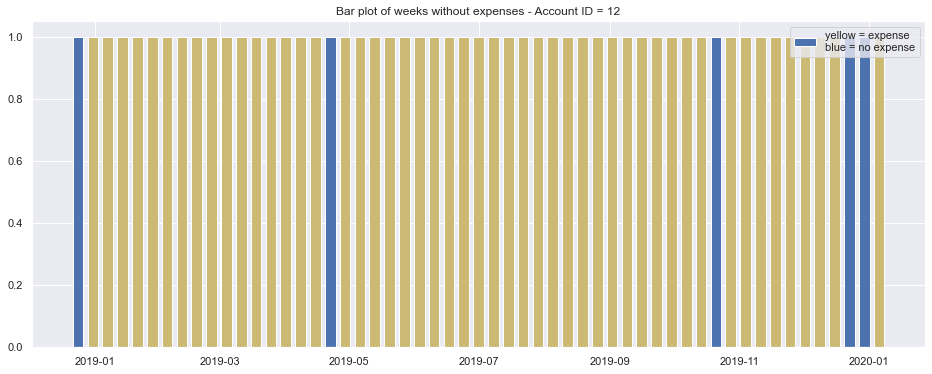

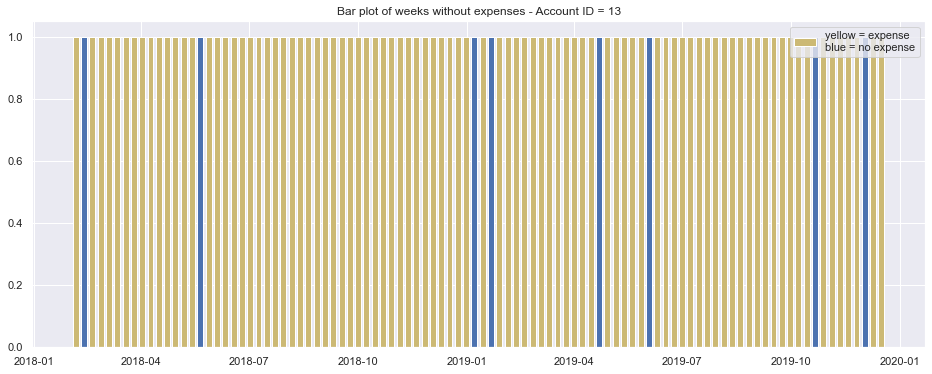

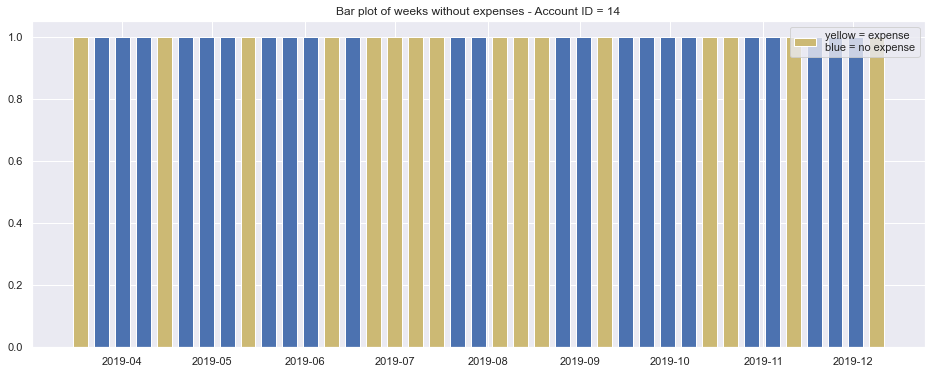

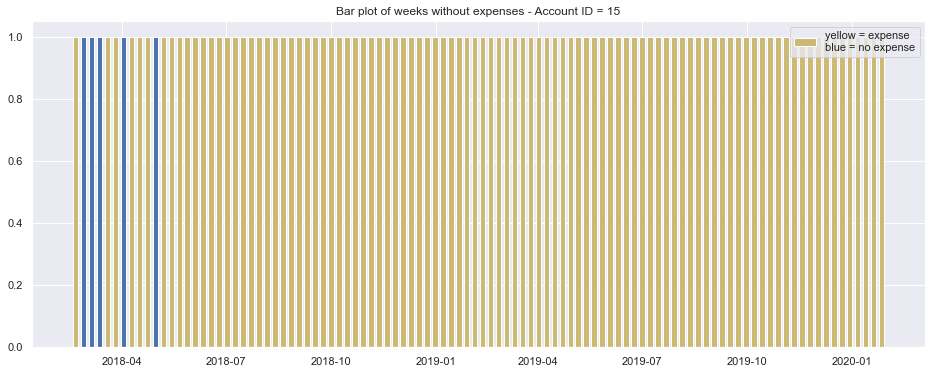

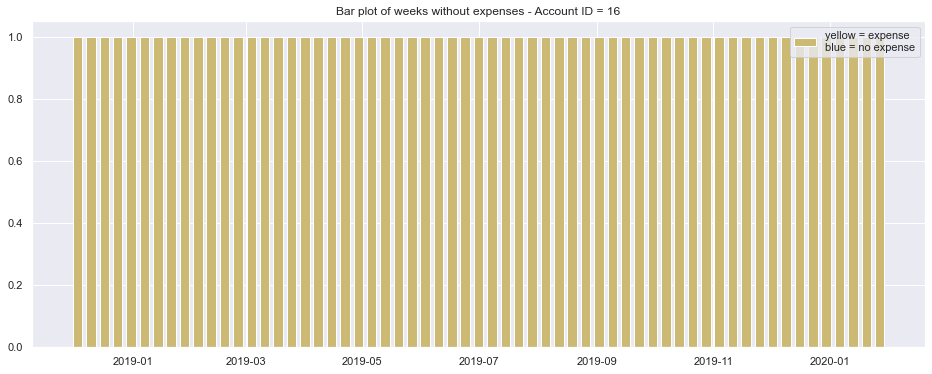

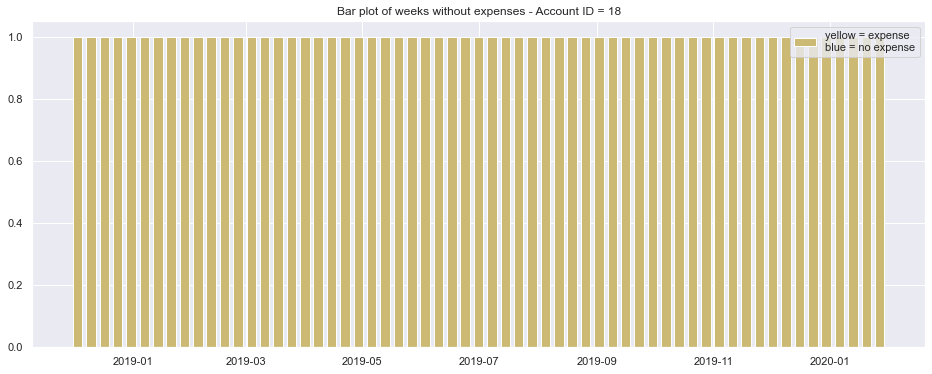

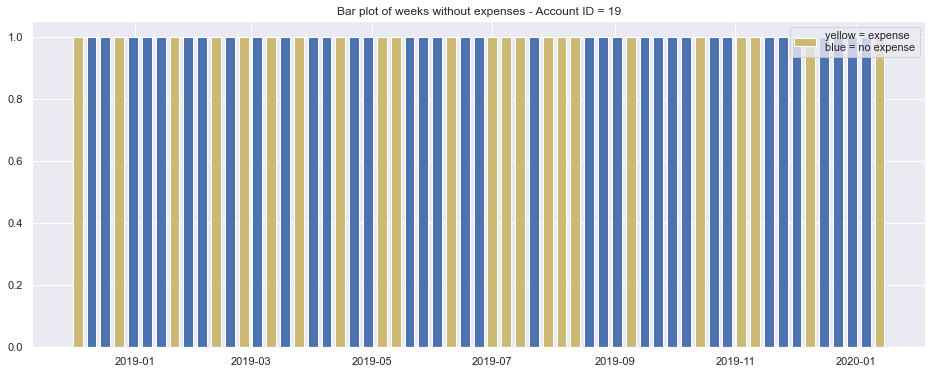

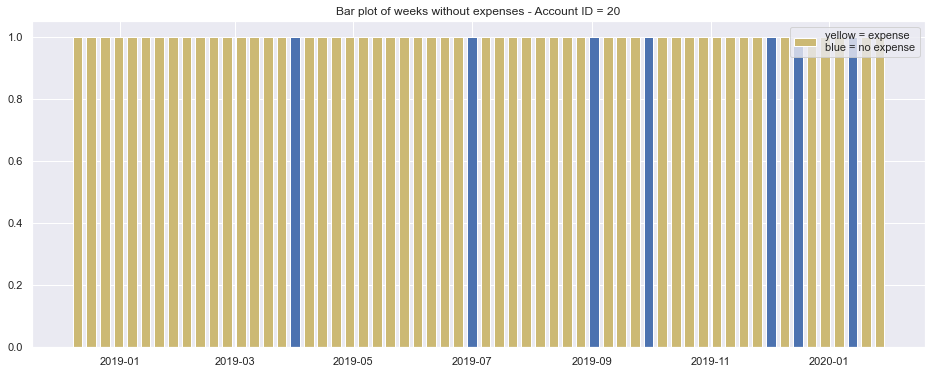

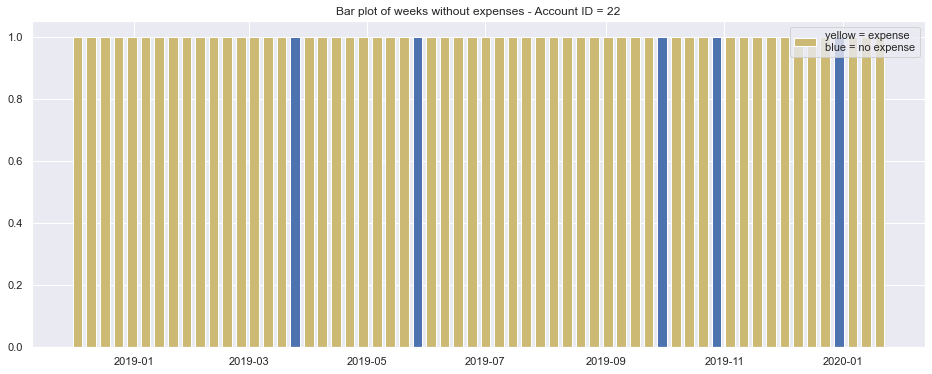

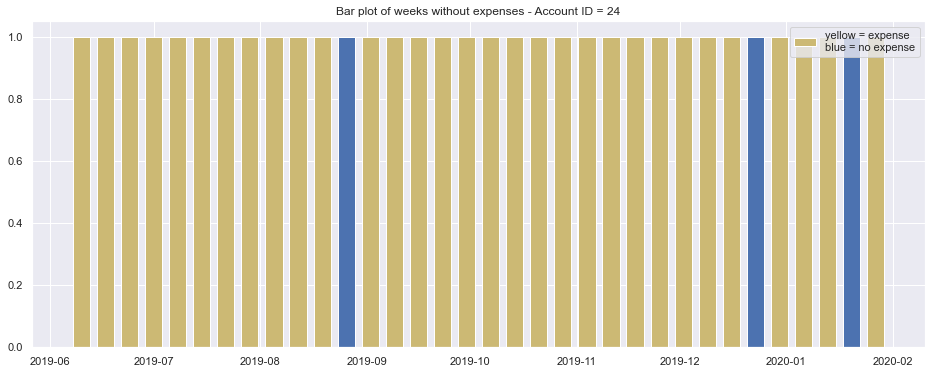

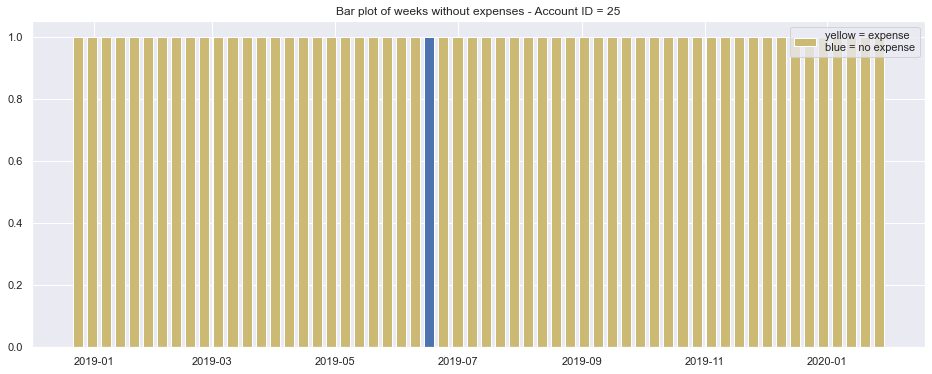

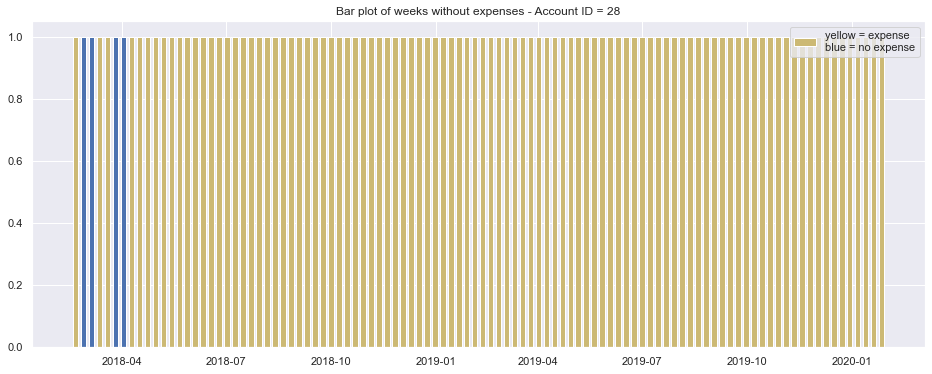

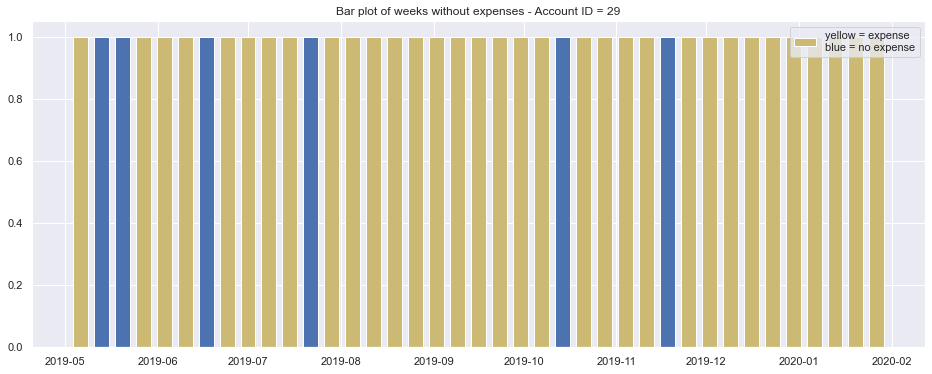

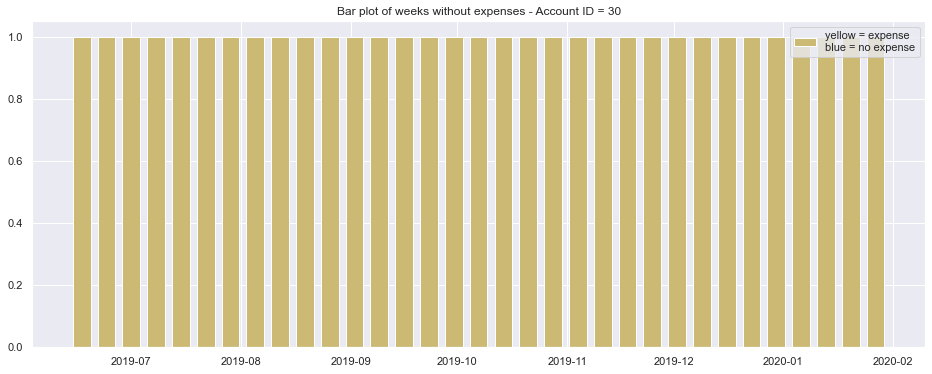

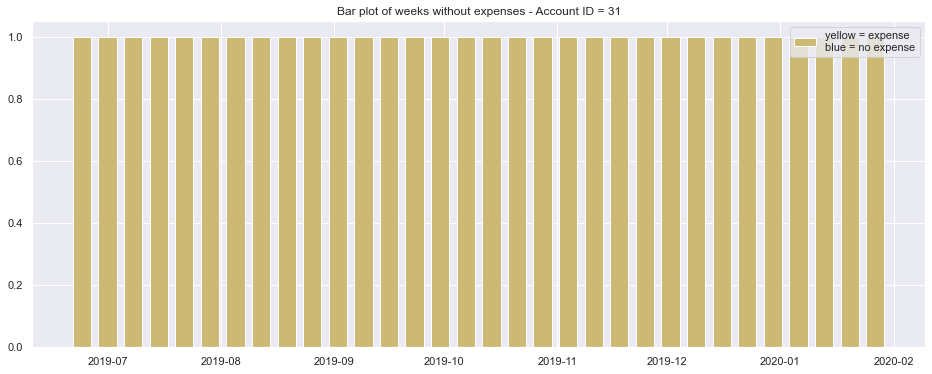

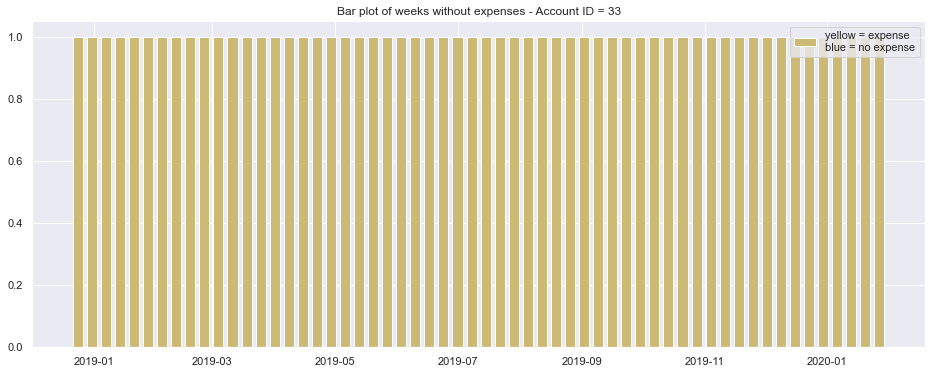

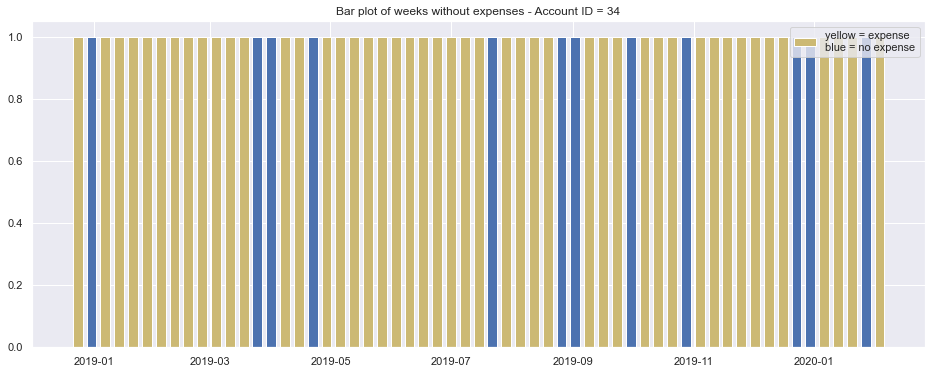

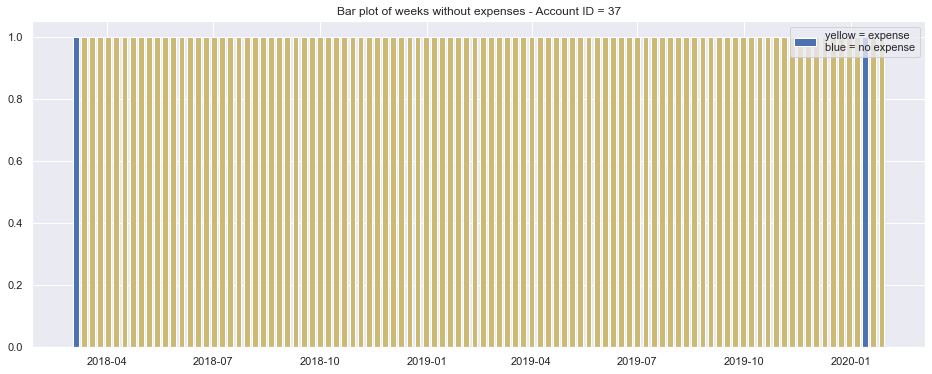

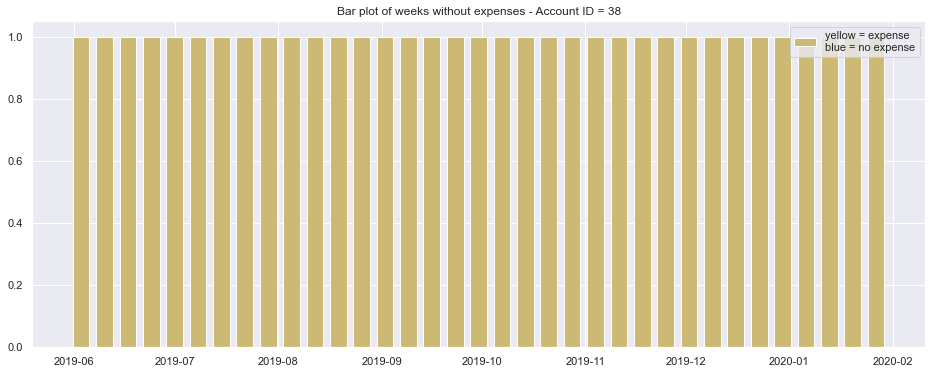

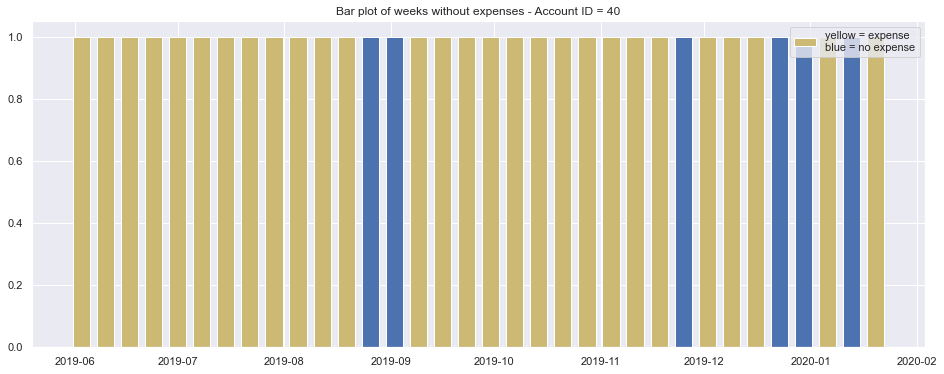

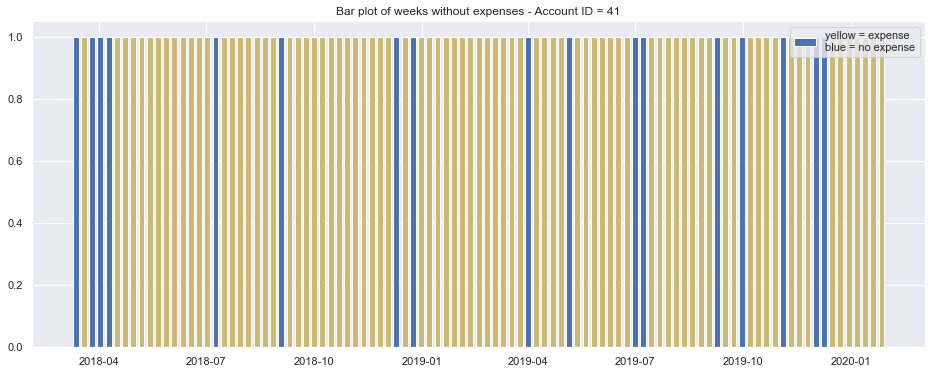

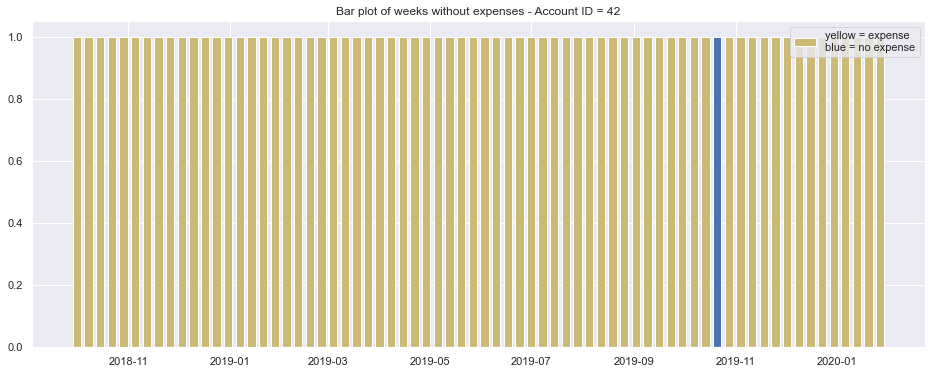

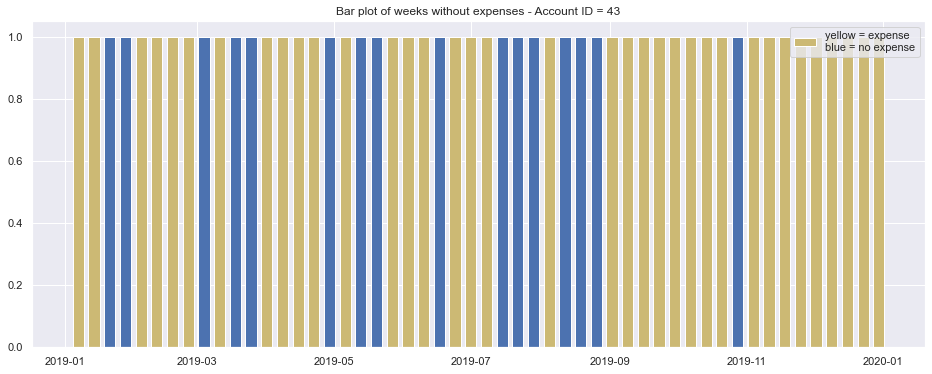

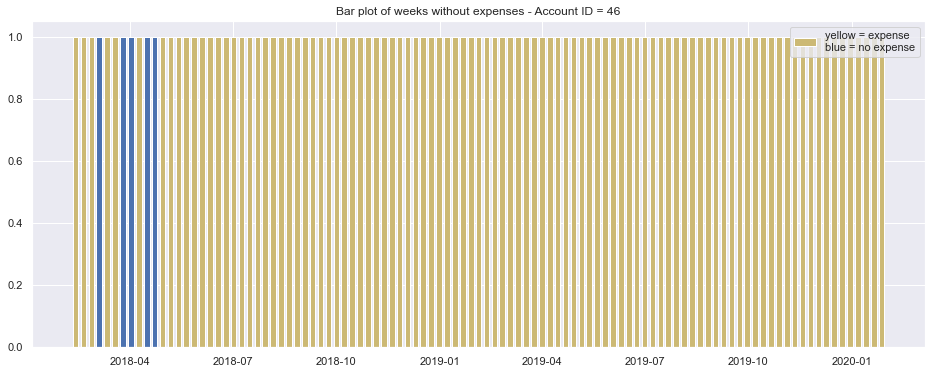

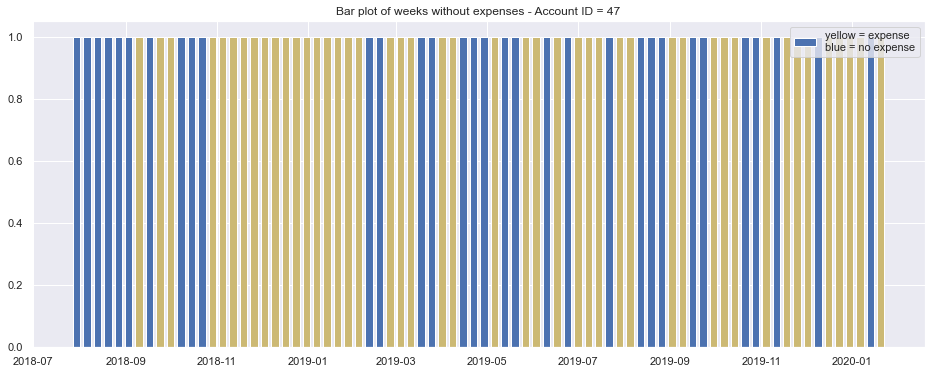

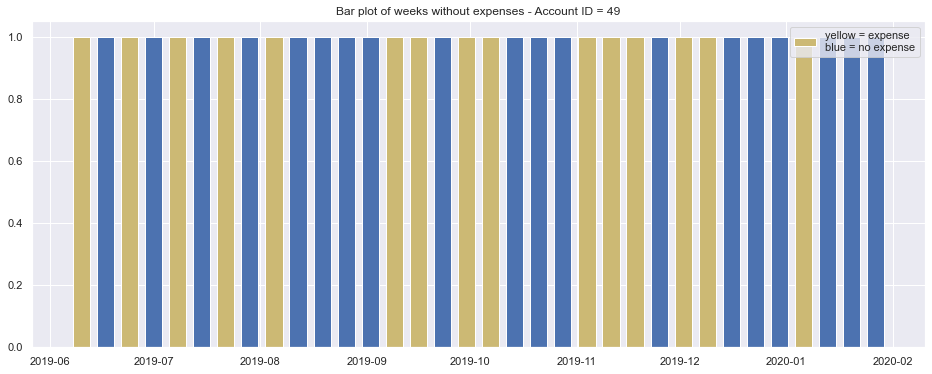

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [135]:
resampled_trasactions = get_new_resample_expenses_df(df=df_transactions)

for account_id in df_accounts["id"].unique():
    plt.figure(figsize=(16, 6))
    temp_df = resampled_trasactions[resampled_trasactions["account_id"] == account_id]
    mask_no_expenses = temp_df["amount"] == 0
    plt.bar(
        temp_df["date"],
        np.ones(len(mask_no_expenses)),
        color=[["y", "b"][idx] for idx in mask_no_expenses],
        width=5,
        label="yellow = expense\nblue = no expense",
    )
    plt.title(
        f"Bar plot of weeks without expenses - Account ID = {account_id}", fontsize=12
    )
    plt.legend()

From the plot we observe that some account lack of data: blue bars. For example, the account ID number 14 have less weeks with data than without data. 

I'm wondering if another datetime condition shouldn't be added: since we are looking at the last 12 weeks of data before making a prediction, shouldn't be at least N weeks containing data in those 12 weeks? 

The code source in the coding test does only look at the number of weeks between the oldest and the latest transaction `validate_transaction_history` and not the number of weeks with data. I may want to keep the same filter to both train and test data. However I think that it's best to remove these accounts from the training data set.

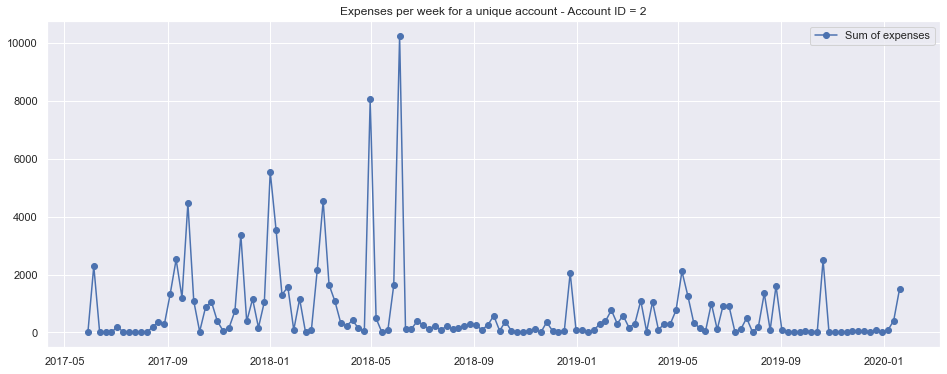

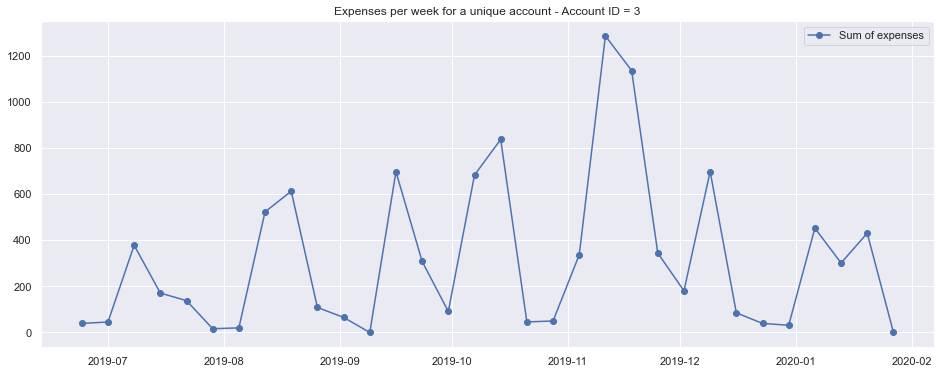

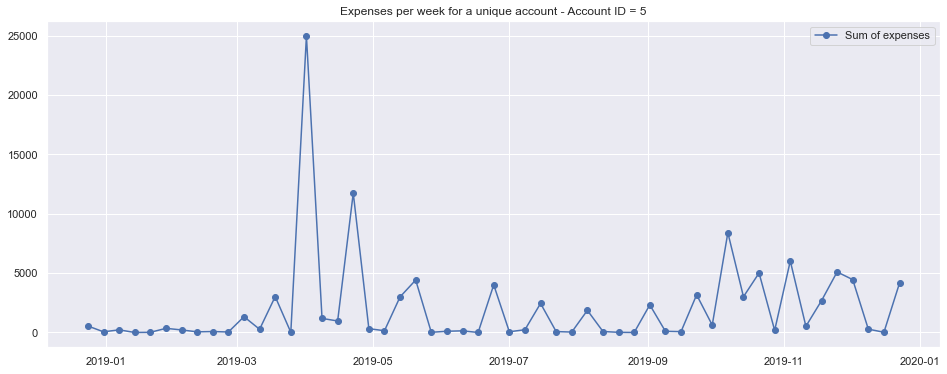

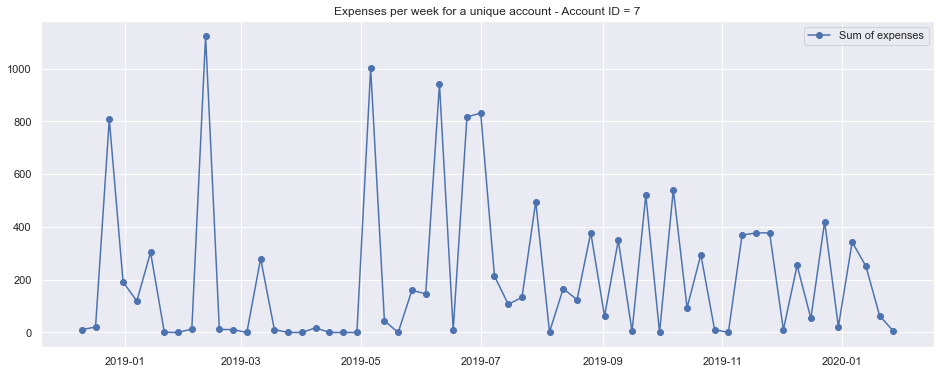

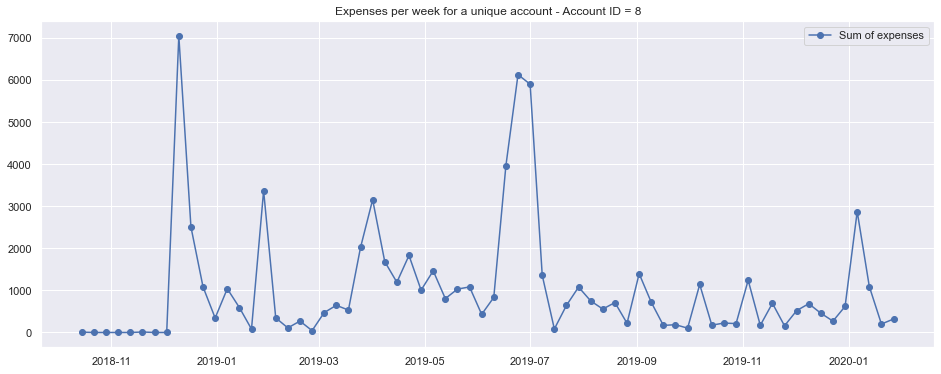

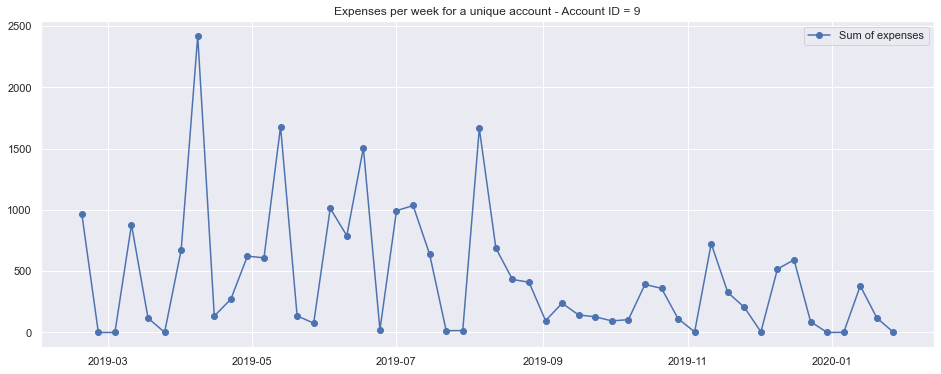

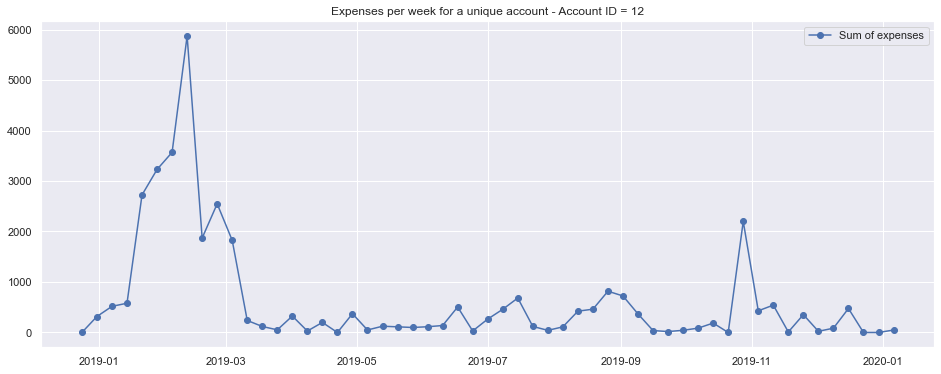

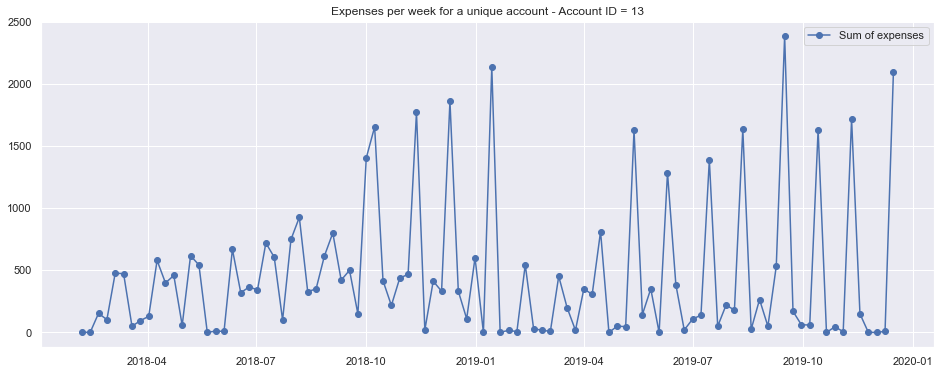

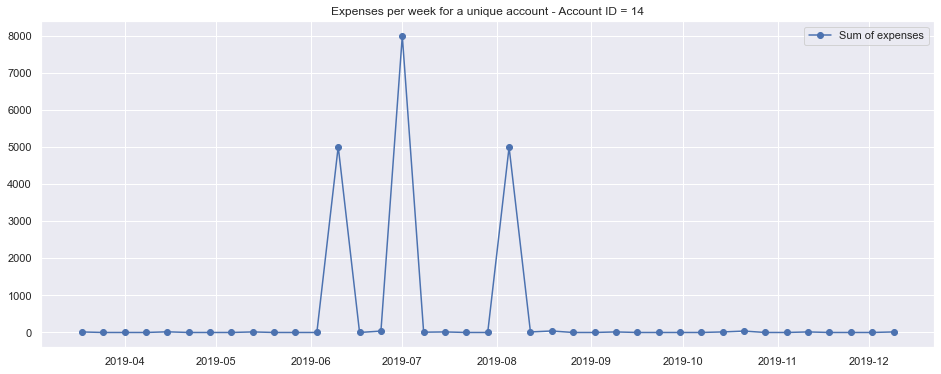

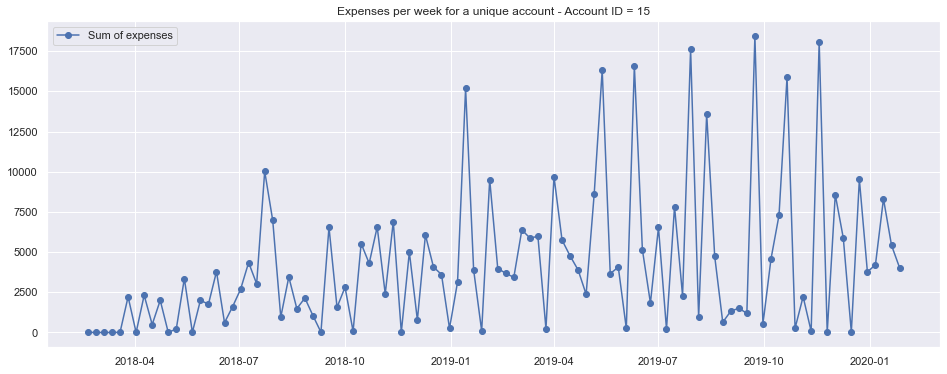

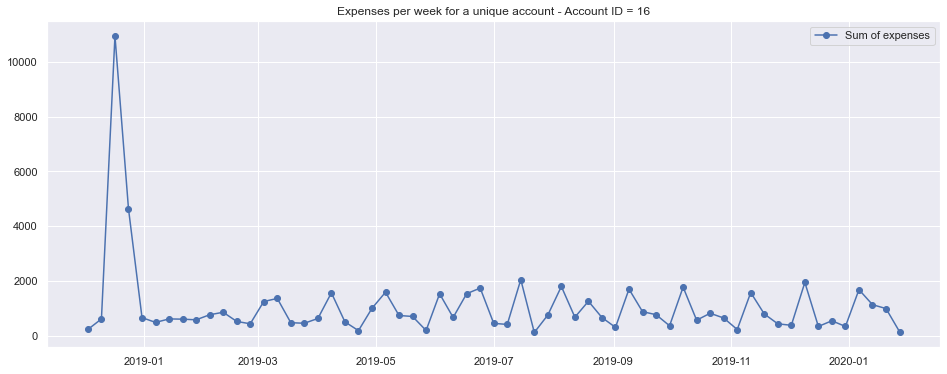

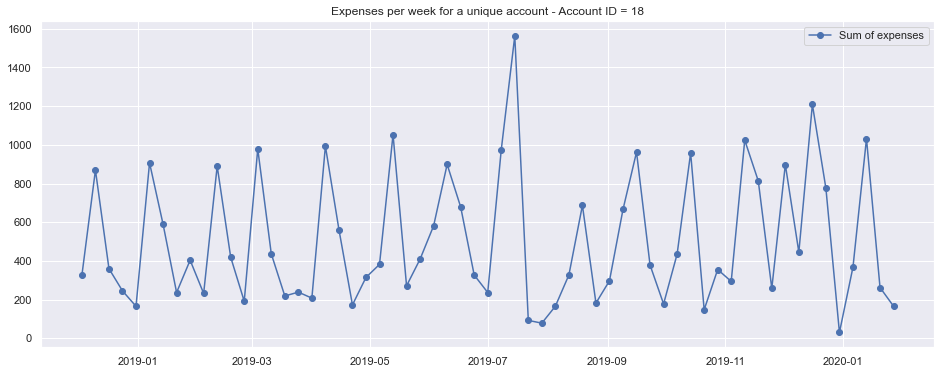

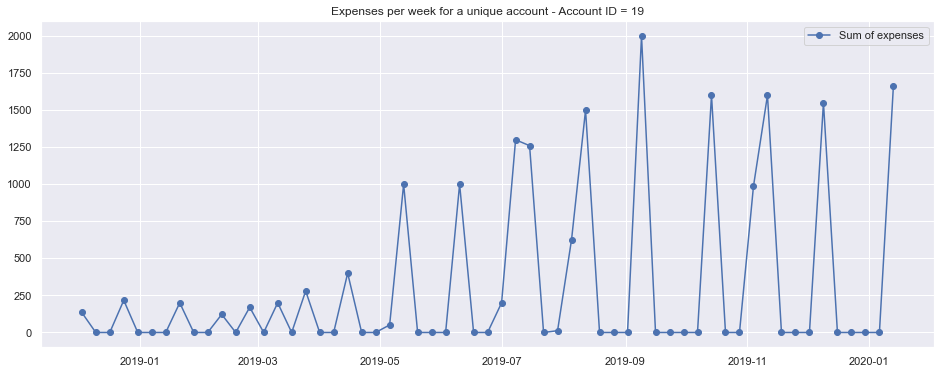

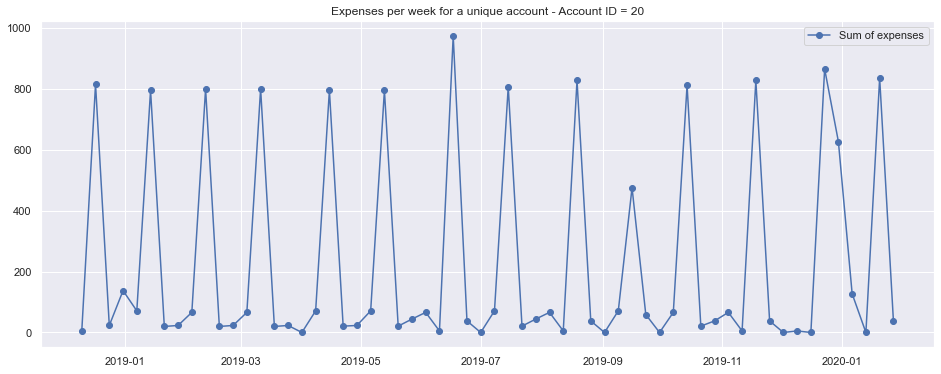

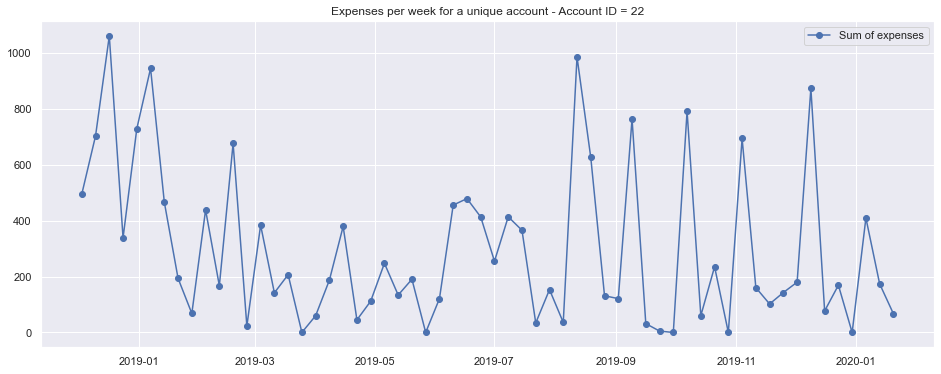

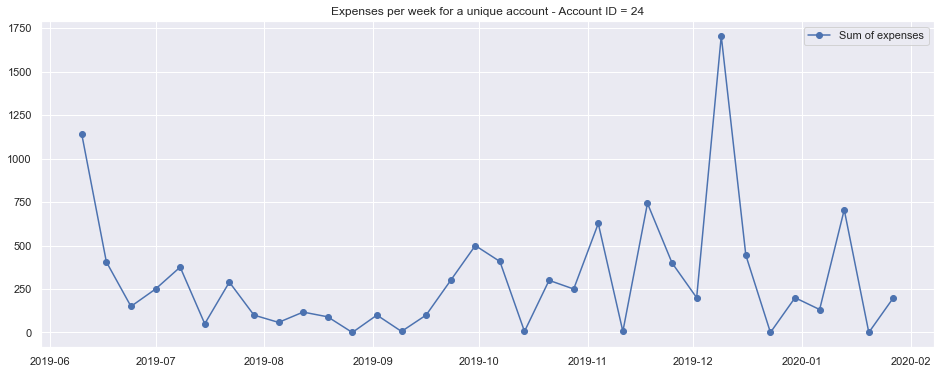

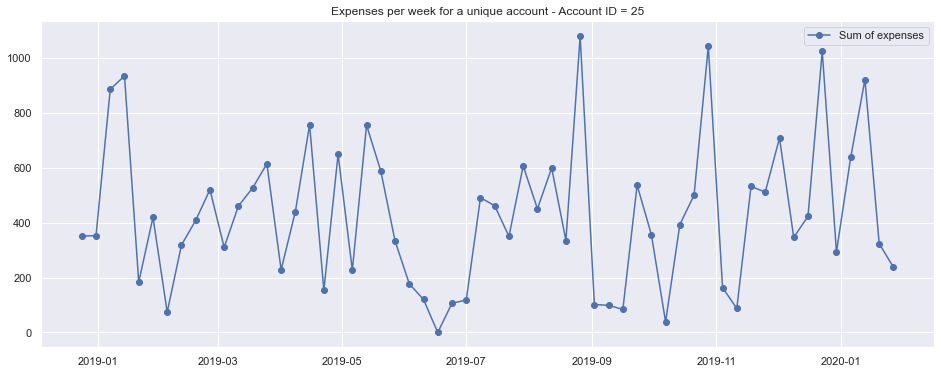

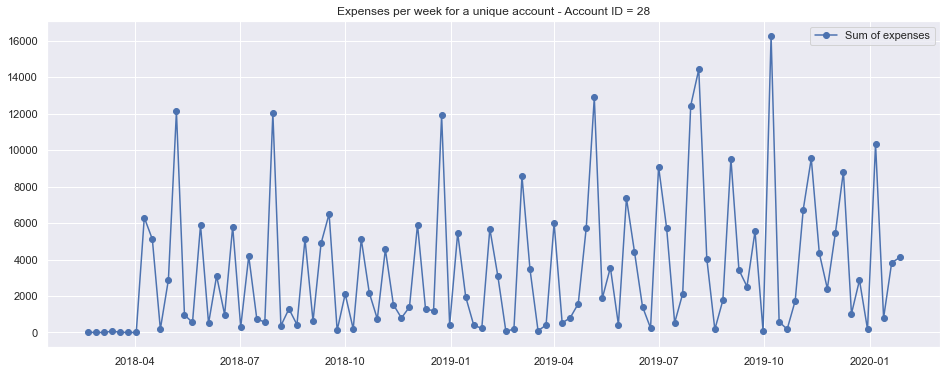

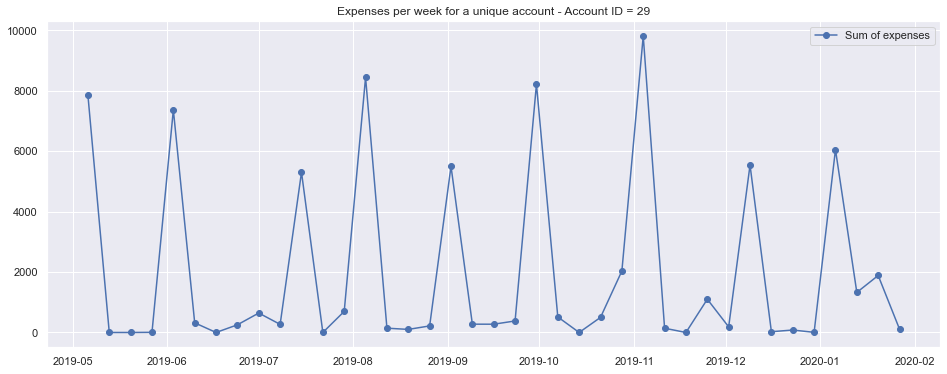

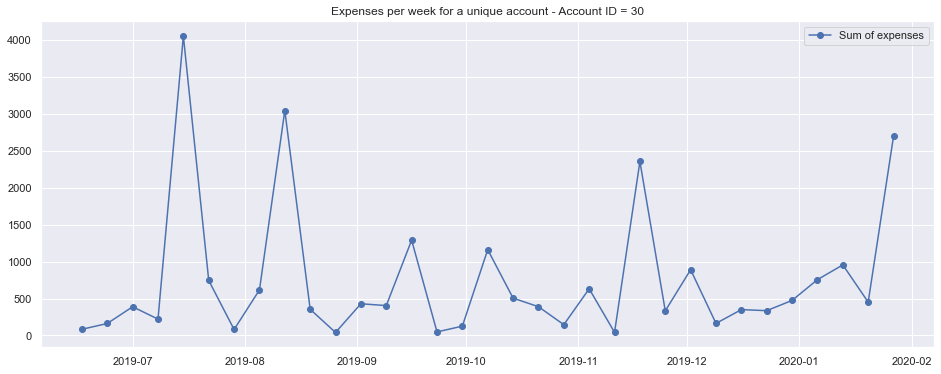

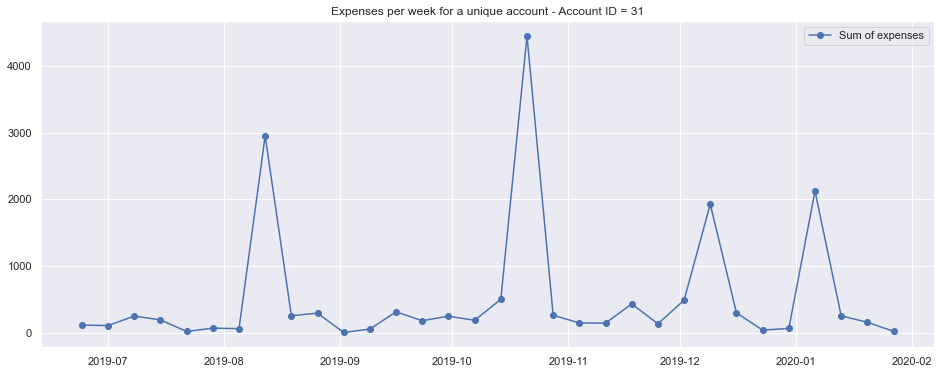

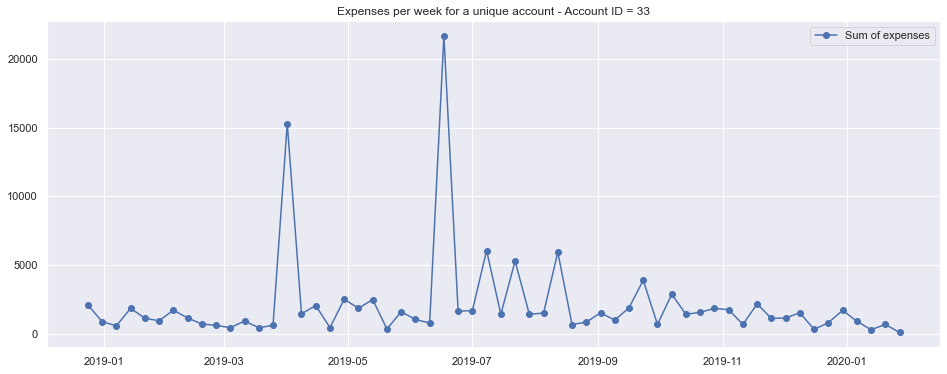

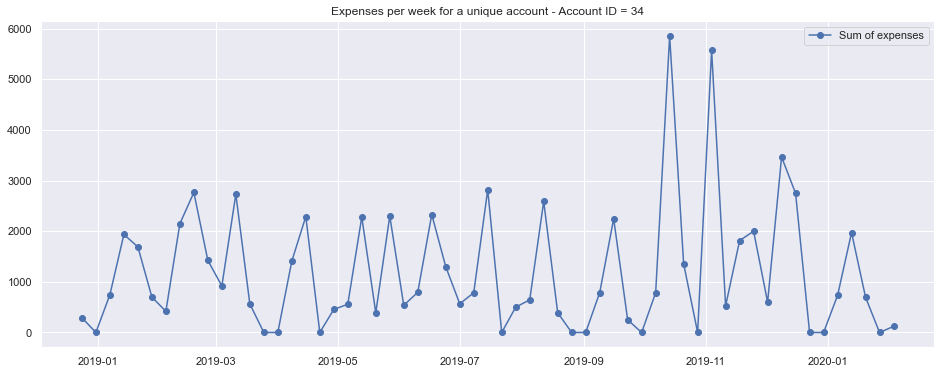

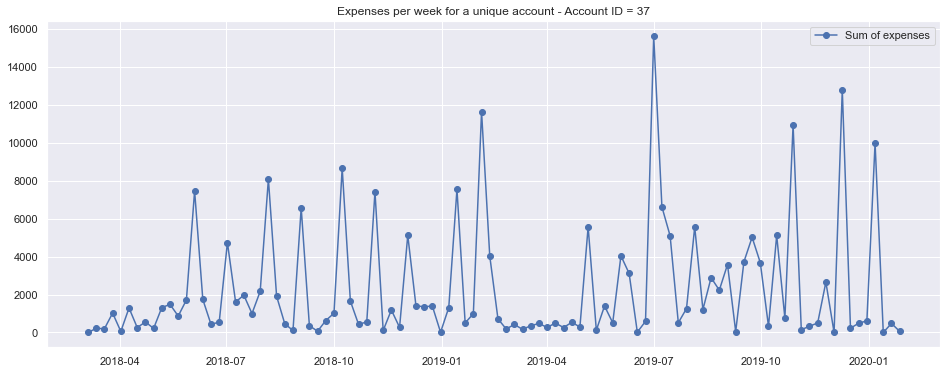

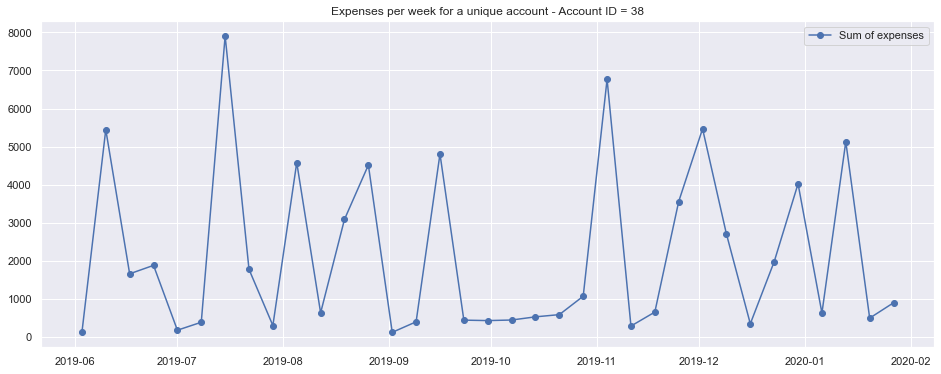

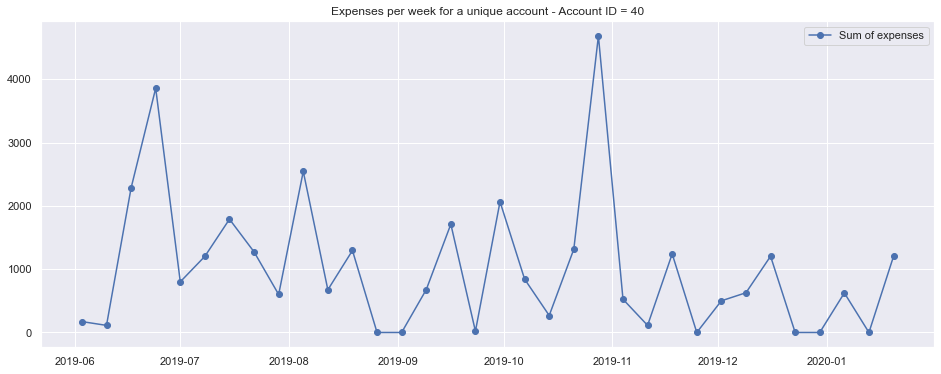

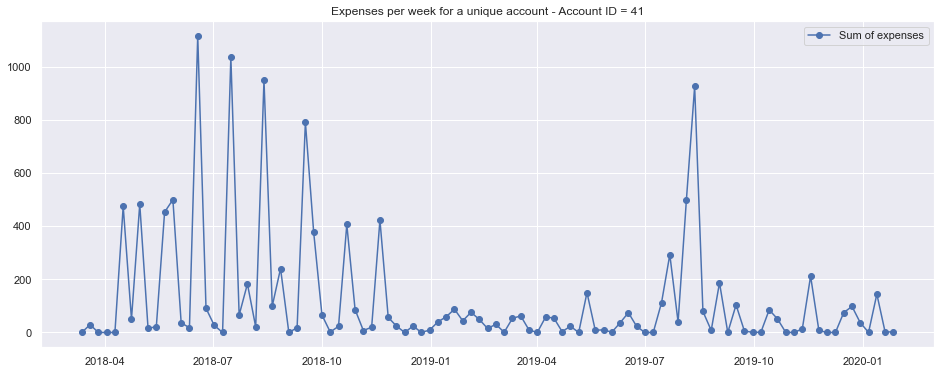

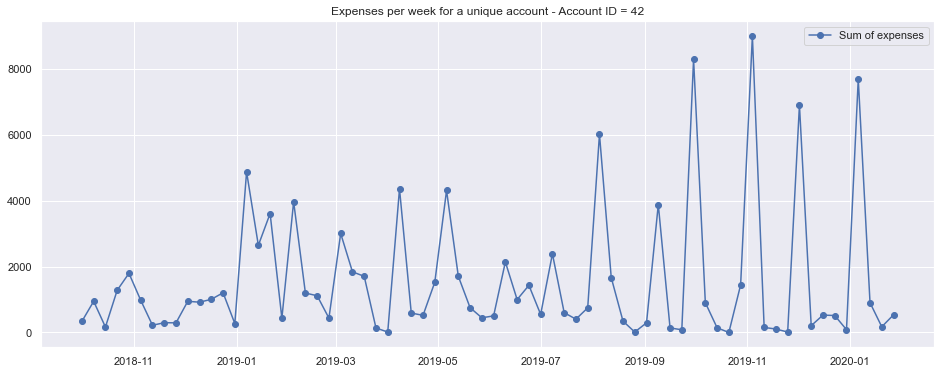

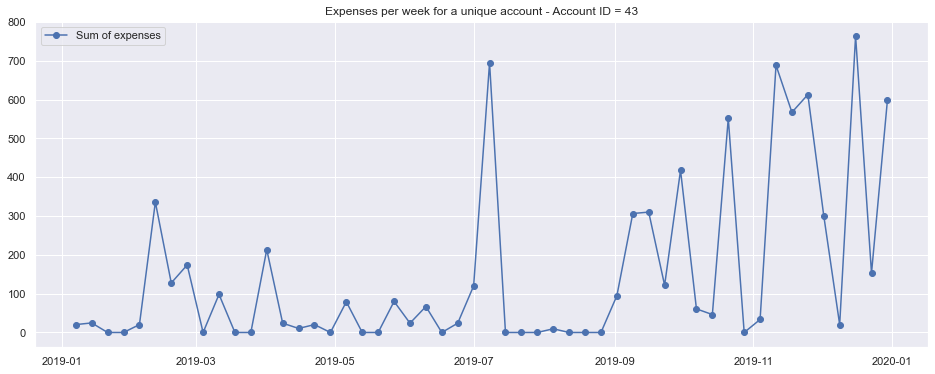

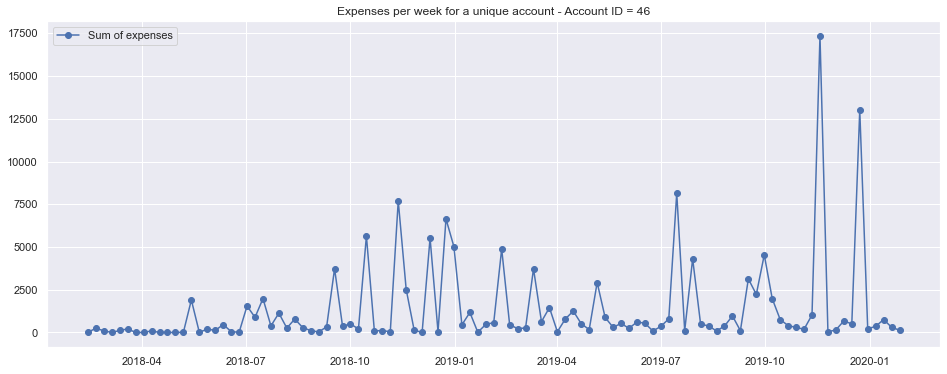

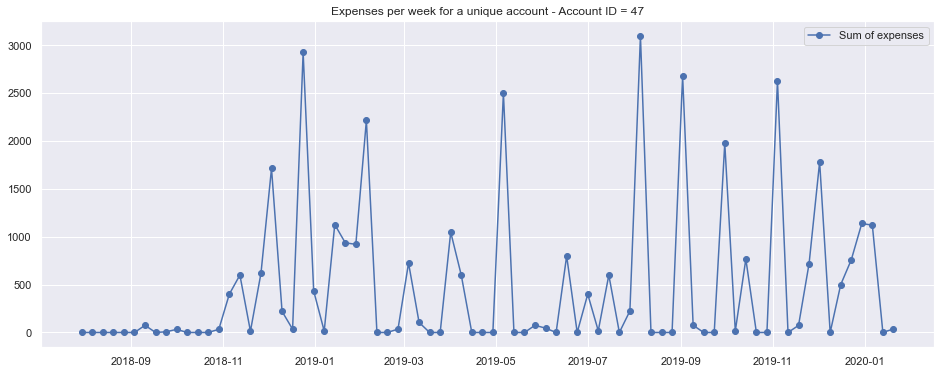

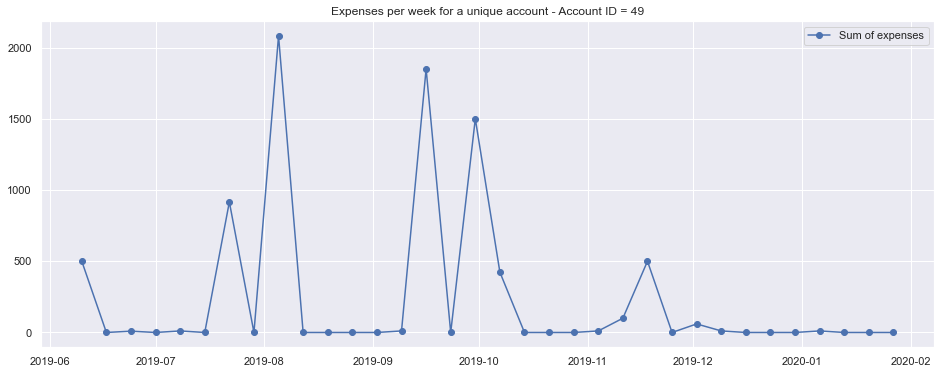

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [137]:
import math

for account_id in df_accounts["id"].unique():
    plt.figure(figsize=(16, 6))
    temp_df = resampled_trasactions[resampled_trasactions["account_id"] == account_id]
    plt.plot(
        temp_df["date"],
        abs(temp_df["amount"]),
        # [math.log(max(1, abs(amount))) for amount in temp_df["amount"]],
        "-o",
        label="Sum of expenses",
    )

    plt.title(
        f"Expenses per week for a unique account - Account ID = {account_id}",
        fontsize=12,
    )
    plt.legend()

- Some accounts show seasonality when plotting their expenses per week.
- It seems that there is not much trend in the plots.

Let us check the stationarity of data using the augmented Dicker-Fuller test. 

In [118]:
adf_pvalue_dict = {}


for account_id in df_accounts["id"].unique():
    temp_df = resampled_trasactions[resampled_trasactions["account_id"] == account_id]
    ad_fuller_result = adfuller(temp_df["amount"])
    adf_pvalue_dict[account_id] = ad_fuller_result[1]

# print(f'ADF Statistic: {ad_fuller_result[0]}')
# print(f'p-value: {ad_fuller_result[1]}')

<IPython.core.display.Javascript object>

In [119]:
adf_pvalue_dict

{2: 0.03896610534825408,
 3: 0.5382845822856338,
 5: 2.4967975080582258e-11,
 7: 1.834976202507158e-14,
 8: 3.294375795016996e-05,
 9: 0.5108197212492894,
 12: 0.02771350081136827,
 13: 0.23526353805668843,
 14: 1.2012325408913776e-08,
 15: 1.8892921241141306e-20,
 16: 2.6521388117711684e-17,
 18: 0.00637674122433812,
 19: 0.3983152726117295,
 20: 3.6161211977118373e-17,
 22: 0.049418668529599113,
 24: 2.4175431663748953e-07,
 25: 3.538478192775074e-10,
 28: 0.09310727246775713,
 29: 3.6131779581715255e-10,
 30: 2.5647301404932463e-07,
 31: 7.583717458288675e-07,
 33: 3.117004244025716e-12,
 34: 1.0387641948172442e-09,
 37: 0.0004478362610929941,
 38: 4.8590674245510604e-08,
 40: 4.022209477718384e-06,
 41: 0.050750713807250665,
 42: 0.028313552719319922,
 43: 0.706883764212471,
 46: 1.1914431364295832e-18,
 47: 0.055995886982676255,
 49: 0.5930408316861736}

<IPython.core.display.Javascript object>